In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from datetime import datetime, date
import janitor as jn
import humanize 

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Cleaning

In [237]:
data = pd.read_csv('biofilm_2018_all.csv')

# Standard Janitor routines.
data = jn.DataFrame(data).clean_names().remove_empty()
# Add a date column.
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['date_humanized'] = data['date'].apply(lambda x: humanize.naturaldate(x))

# Get 3 columns of coded categoricals for ease of use with PyMC3.
data['date_coded'] = pd.Categorical(data['date']).codes
data['isolate_coded'] = pd.Categorical(data['isolate']).codes
data['st_coded'] = pd.Categorical(data['st']).codes

# View a sample of columns
data.sample(5)

,isolate,st,replicate,od600,od570,reblanked_od,normalized_od570,month,day,year,expt,date,date_humanized,date_coded,isolate_coded,st_coded
310,83,48,11,0.505,0.716,NaN,1.417822,1,19,2018,1,2018-01-19,Jan 19,3,5,1
403,83,48,2,0.472,0.299,NaN,0.633475,1,25,2018,2,2018-01-25,Jan 25,4,5,1
182,13,4,3,0.510,0.492,NaN,0.964706,1,12,2018,4,2018-01-12,Jan 12,2,1,0
453,58,48,4,0.475,1.878,NaN,3.953684,2,2,2018,3,2018-02-02,Feb 02,5,4,1
312,86,48,1,0.571,0.407,NaN,0.712785,1,19,2018,1,2018-01-19,Jan 19,3,7,1


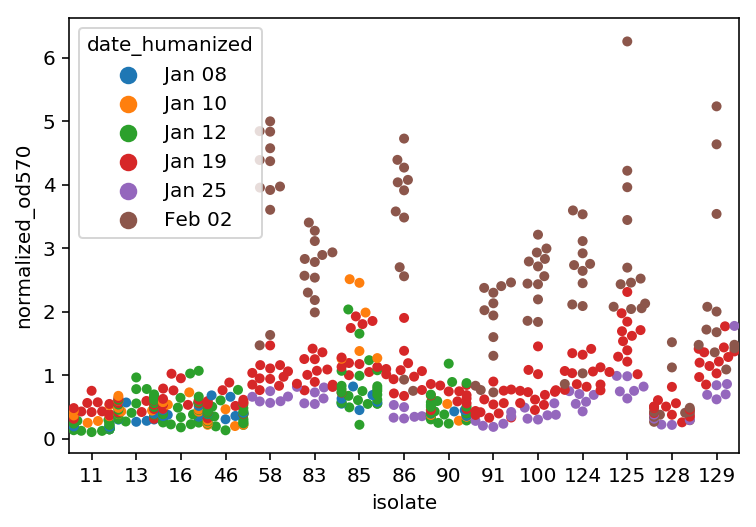

In [239]:
import seaborn as sns
sns.swarmplot(x='isolate', y='normalized_od570', hue='date_humanized', data=data)

Based on this, there is a clear batch effect based on measurement dates, and thus those must be controlled for or at least modelled.

The way I'll approach this is as follows:

1. I will do a complete analysis for all isolates measured on date 2018-01-09.

In [240]:
sorted(set(data['date']))

[Timestamp('2018-01-08 00:00:00'),
 Timestamp('2018-01-10 00:00:00'),
 Timestamp('2018-01-12 00:00:00'),
 Timestamp('2018-01-19 00:00:00'),
 Timestamp('2018-01-25 00:00:00'),
 Timestamp('2018-02-02 00:00:00')]

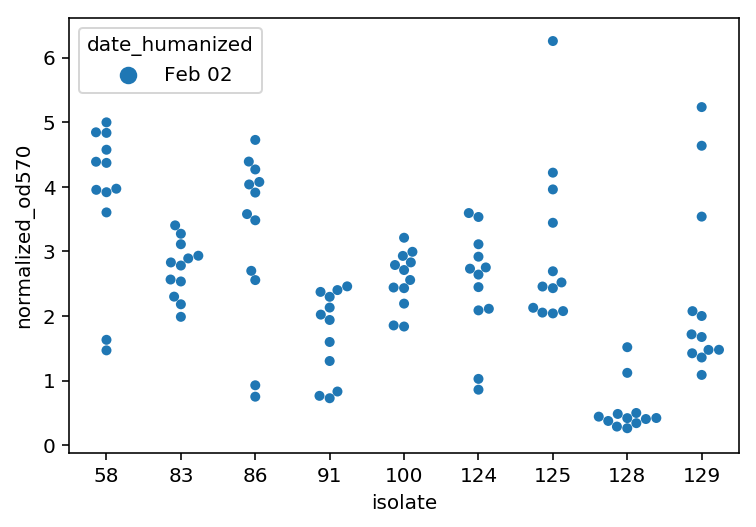

In [242]:
date_code = 5
data_subdate = data[data['date_coded'] == date_code]
sns.swarmplot(x='isolate', y='normalized_od570', hue='date_humanized', data=data_subdate)

In [267]:
with pm.Model() as specific_date_model:
    data_subdate['isolate_coded'] = pd.Categorical(data_subdate['isolate']).codes
    shape = len(set(data_subdate['isolate_coded']))
    print(shape)
    mu_all = pm.Normal('mu_all', mu=0, sd=100, shape=(shape,))
    sd_all = pm.HalfCauchy('sd_all', beta=1, shape=(shape,))
    nu = pm.Exponential('nu', lam=0.5)
    
    mu = mu_all[data_subdate['isolate_coded']]
    sd = sd_all[data_subdate['isolate_coded']]
    
    like = pm.StudentT('like', mu=mu, sd=sd, nu=nu, observed=data_subdate['normalized_od570'])

/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


9


In [269]:
with specific_date_model:
    specific_date_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:05<00:00, 470.94it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b271be0>,
      dtype=object)

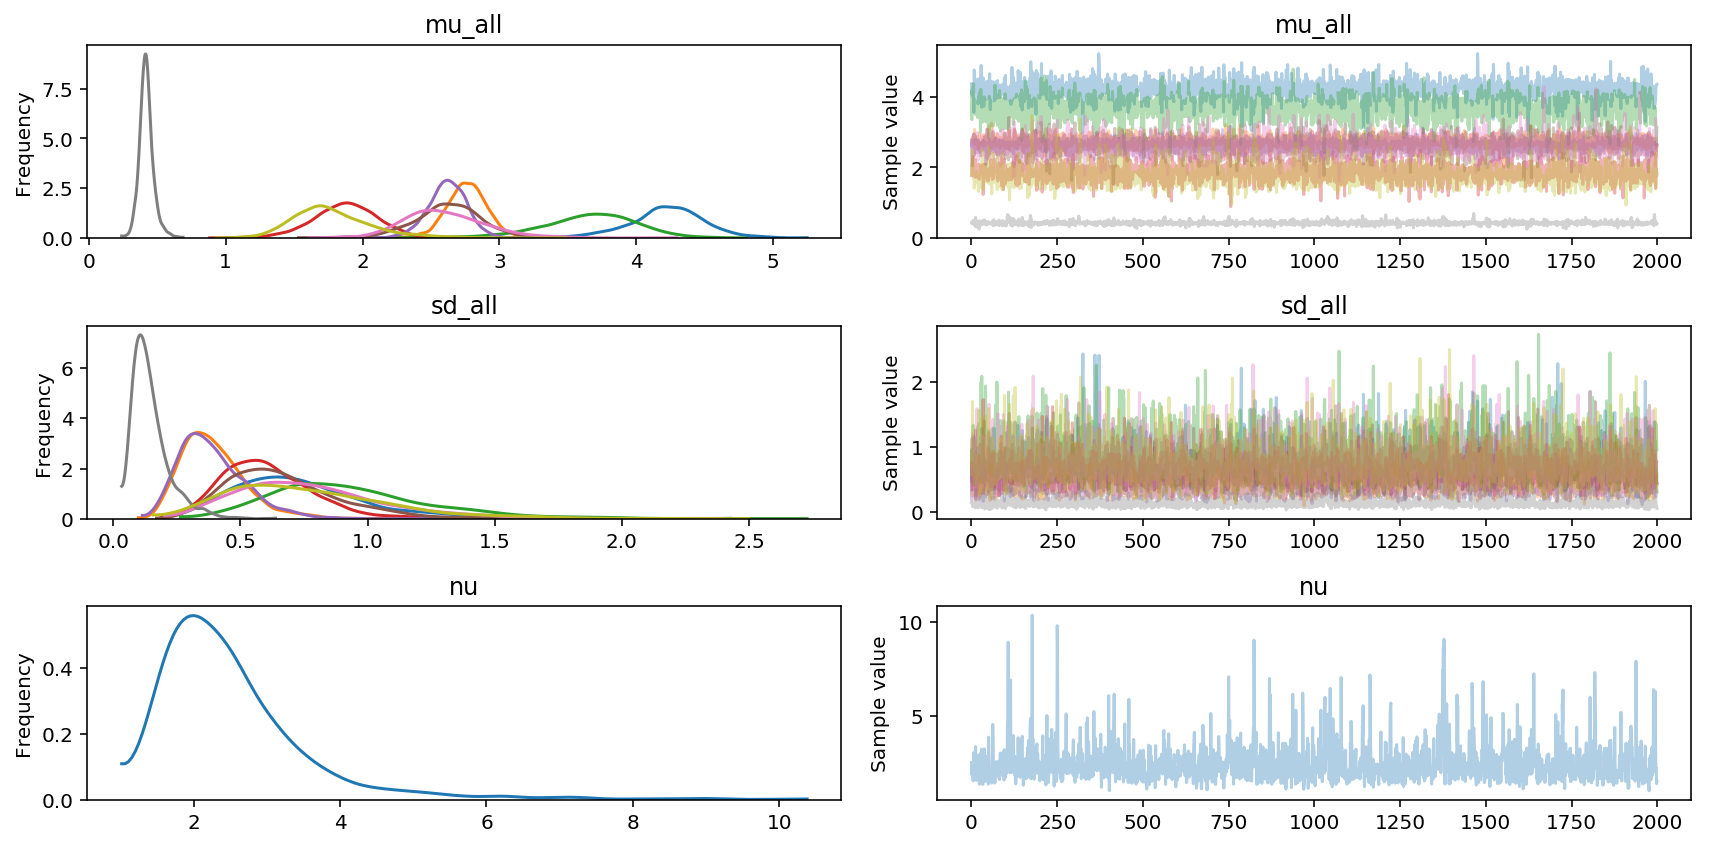

In [270]:
pm.traceplot(specific_date_trace)

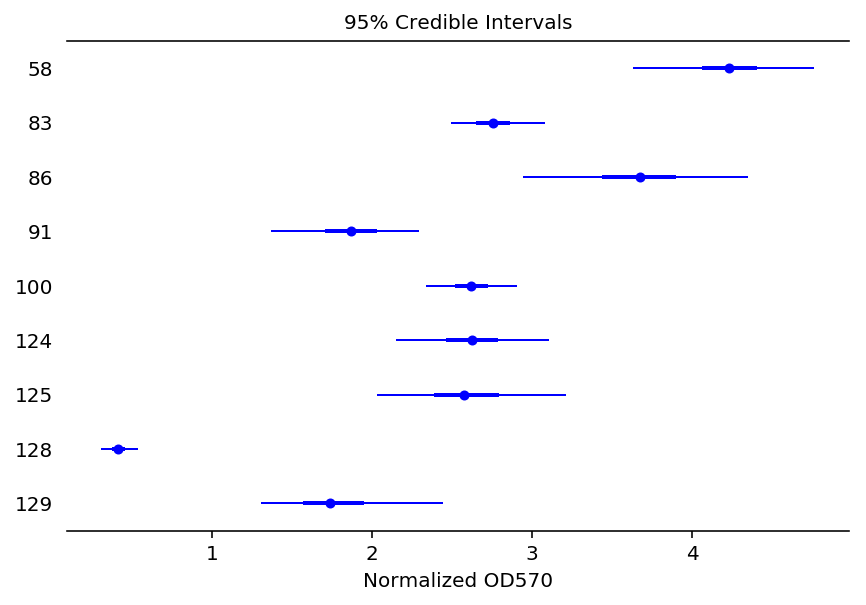

In [271]:
isolates = [str(i) for i in sorted(set(data_subdate['isolate']))]
pm.forestplot(specific_date_trace, varnames=['mu_all'], ylabels=isolates, xtitle='Normalized OD570')

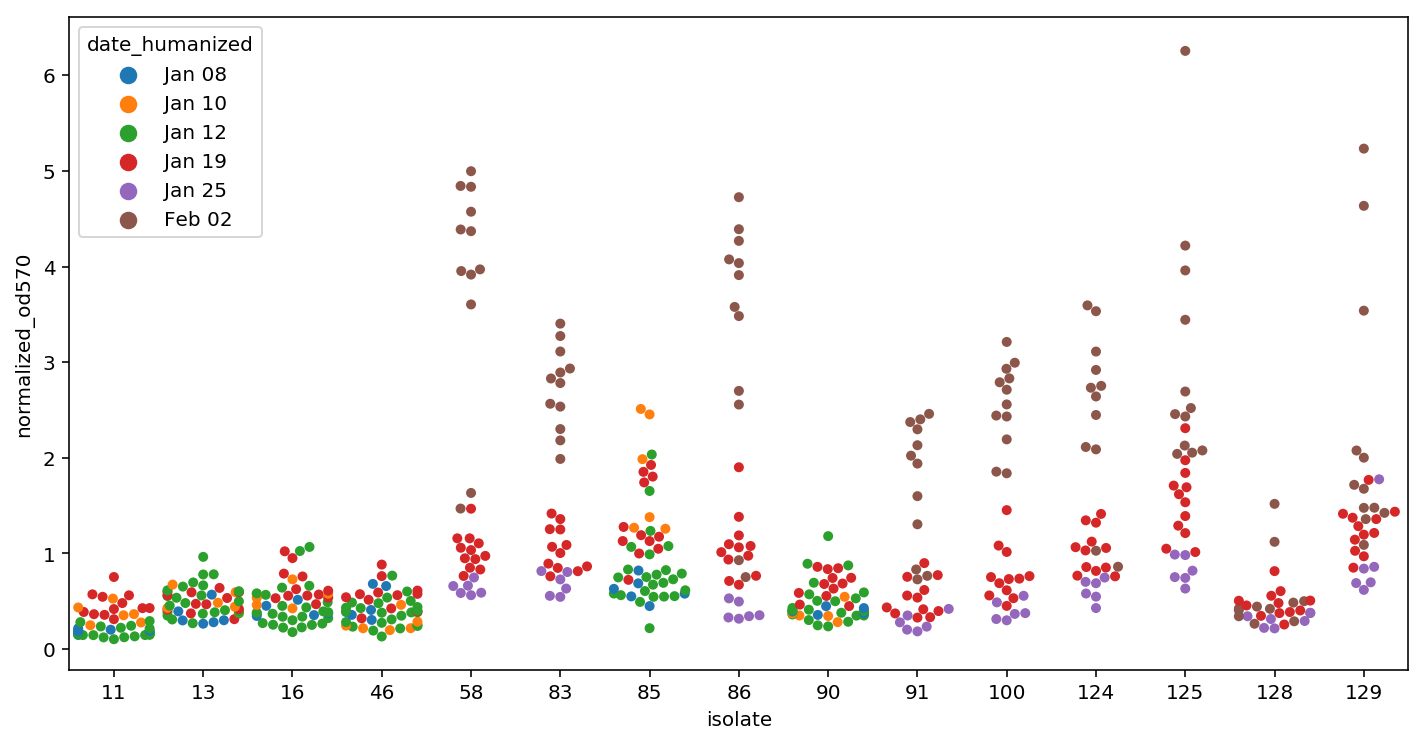

In [247]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
sns.swarmplot(x='isolate', y='normalized_od570', hue='date_humanized', data=data, ax=ax)

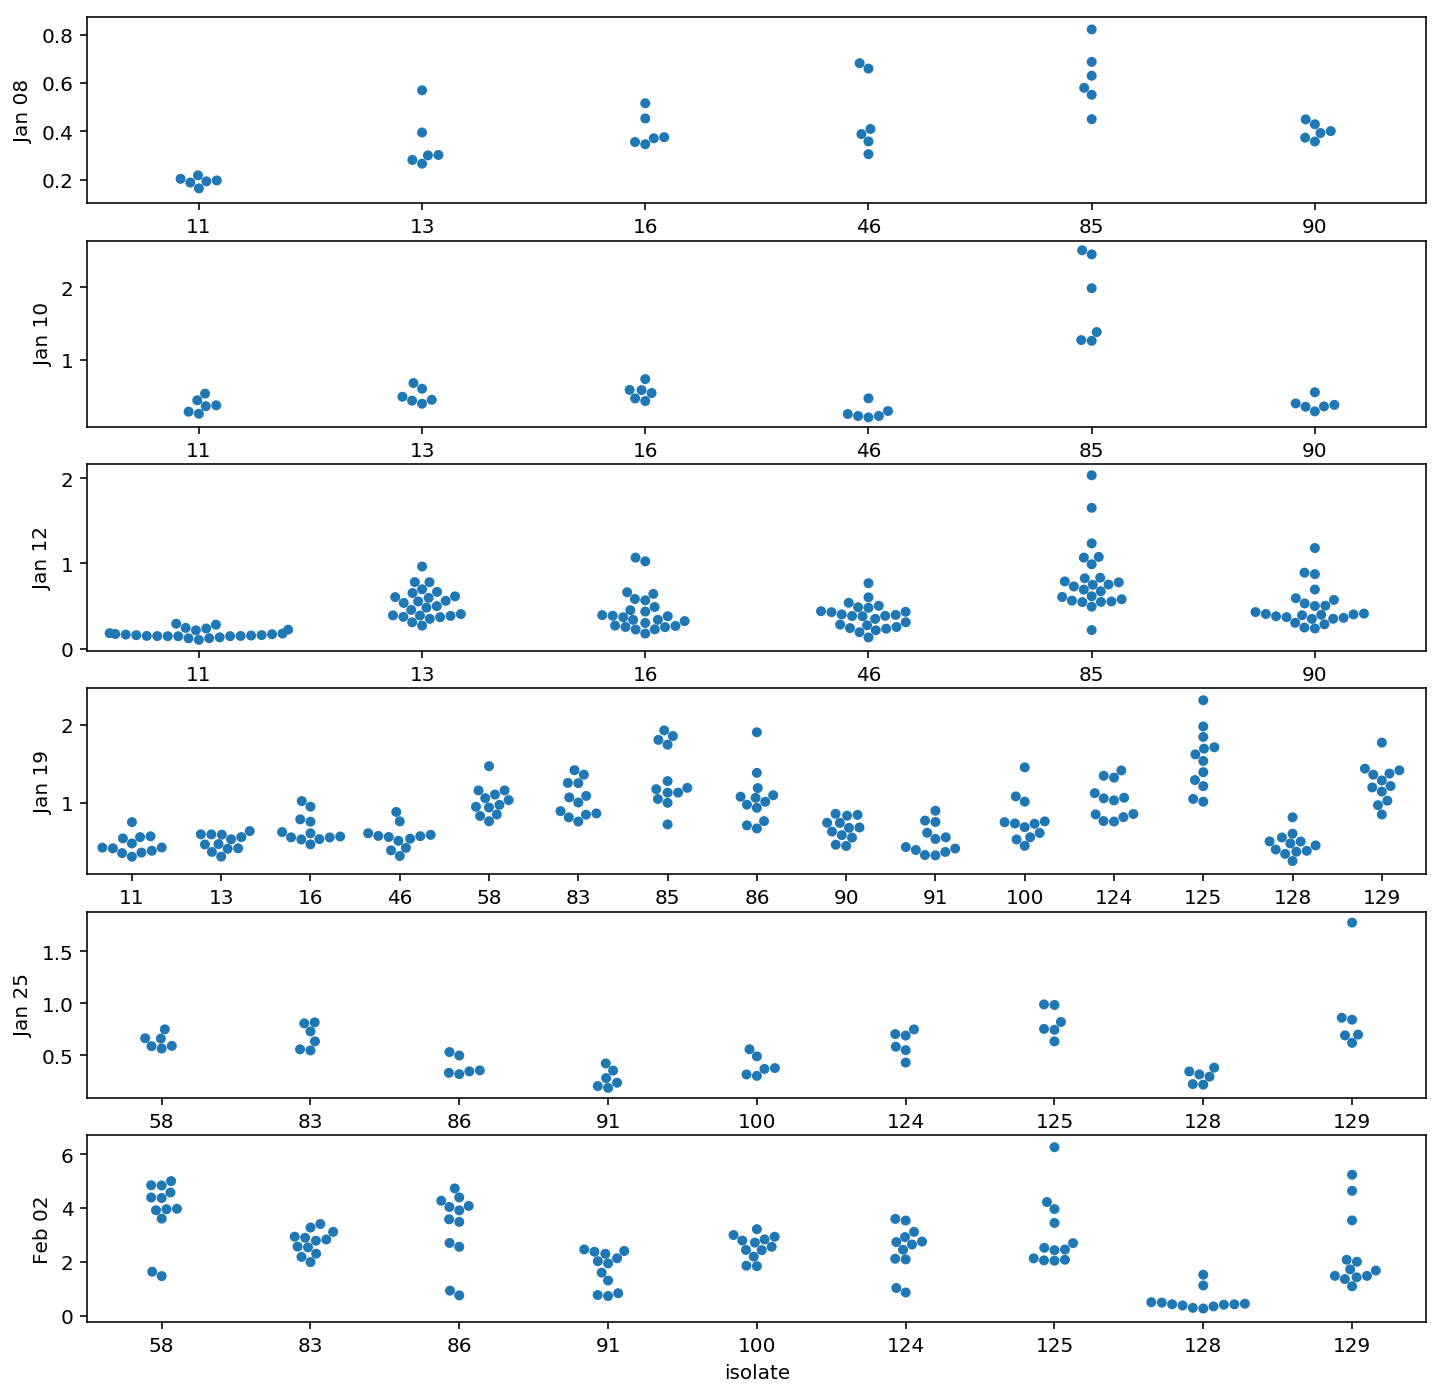

In [264]:
from matplotlib.gridspec import GridSpec
# Let's build a custom swarm plot panel. This is essentially a vertical concatenation of swarm plots.
nrows = len(set(data['date']))
ncols = 1
gs = GridSpec(nrows, ncols)
dates = data[['date_humanized', 'date_coded']].drop_duplicates().set_index('date_coded').to_dict(orient='index')
dates

fig = plt.figure(figsize=(12, 12))
for code in range(6):
    data_subdate = data[data['date_coded'] == code]
    ax = fig.add_subplot(gs[code])
    sns.swarmplot(x='isolate', y='normalized_od570', hue='date', data=data_subdate, ax=ax)
    ax.legend_.remove()
    ax.set_ylabel(f'{dates[code]["date_humanized"]}')

# Analyze All Data Together

In [272]:
# Analyze all data together.
with pm.Model() as model:
    shape = len(set(data['isolate_coded']))
    print(shape)
    mu_all = pm.Normal('mu_all', mu=0, sd=100, shape=(shape,))
    sd_all = pm.HalfCauchy('sd_all', beta=1, shape=(shape,))
    nu = pm.Exponential('nu', lam=0.5)
    
    mu = mu_all[data['isolate_coded']]
    sd = sd_all[data['isolate_coded']]
    
    like = pm.StudentT('like', mu=mu, sd=sd, nu=nu, observed=data['normalized_od570'])

15


In [273]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:08<00:00, 307.27it/s]


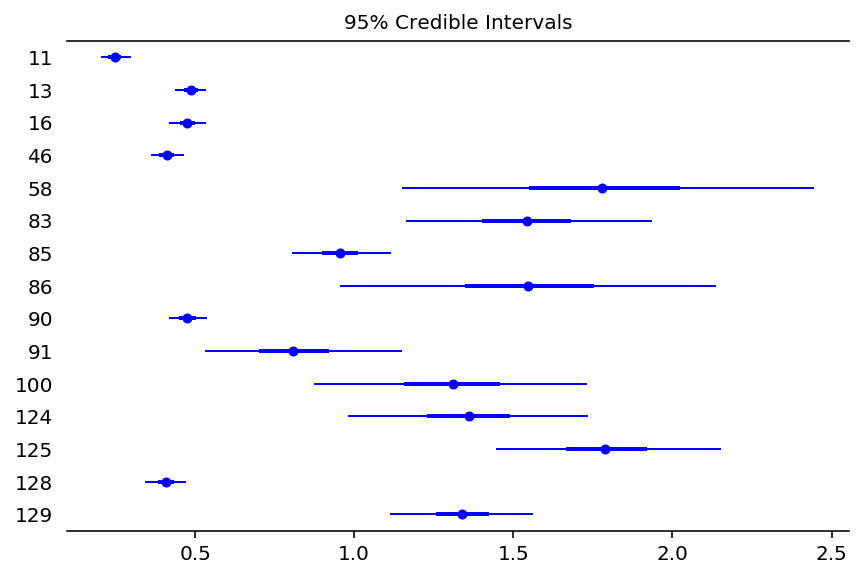

In [276]:
isolates = [str(i) for i in sorted(set(data['isolate']))]
pm.forestplot(trace, varnames=['mu_all'], ylabels=isolates)

In [94]:
normalized_od570_redbatch_mean = (data.groupby(['date', 'isolate'])
                                  .mean()
                                  .loc['2018-01-19']
                                  .reset_index()[['isolate', 'normalized_od570']]
                                  .set_index('isolate')
                                  .to_dict()['normalized_od570'])
normalized_od570_redbatch_mean

{11: 0.46845110866666667,
 13: 0.49919219141666665,
 16: 0.6658424040833334,
 46: 0.5639505585833334,
 58: 1.0252357000833334,
 83: 1.0527076430833333,
 85: 1.3338977914166668,
 86: 1.06630180925,
 90: 0.6743760021666666,
 91: 0.5362154760833334,
 100: 0.7825275625833333,
 124: 1.0351084094166667,
 125: 1.5539503751666663,
 128: 0.4755468185833334,
 129: 1.2541140458333333}

# Shift relative to red

Is there an "average" shift that we can measure, relative to the date 2018-01-19 (red dots)?

In [74]:
shifts = []
for r, d in data.iterrows():
    shift = d['normalized_od570'] - normalized_od570_redbatch_mean[d['isolate']]
    shifts.append(shift)
data['shift'] = shifts
data

,isolate,st,replicate,od600,od570,reblanked_od,normalized_od570,month,day,year,expt,date,date_coded,isolate_coded,st_coded,shift
0,11,55,1,0.517,0.097,NaN,0.187621,1,8,2018,1,2018-01-08,0,0,2,-0.280830
1,11,55,2,0.524,0.114,NaN,0.217557,1,8,2018,1,2018-01-08,0,0,2,-0.250894
2,11,55,3,0.502,0.102,NaN,0.203187,1,8,2018,1,2018-01-08,0,0,2,-0.265264
3,11,55,4,0.477,0.078,NaN,0.163522,1,8,2018,1,2018-01-08,0,0,2,-0.304929
4,11,55,5,0.514,0.099,NaN,0.192607,1,8,2018,1,2018-01-08,0,0,2,-0.275844
5,11,55,6,0.509,0.100,NaN,0.196464,1,8,2018,1,2018-01-08,0,0,2,-0.271987
6,13,4,1,0.538,0.143,NaN,0.265799,1,8,2018,1,2018-01-08,0,1,0,-0.233393
7,13,4,2,0.433,0.130,NaN,0.300231,1,8,2018,1,2018-01-08,0,1,0,-0.198961
8,13,4,3,0.457,0.138,NaN,0.301969,1,8,2018,1,2018-01-08,0,1,0,-0.197223
9,13,4,4,0.562,0.222,NaN,0.395018,1,8,2018,1,2018-01-08,0,1,0,-0.104174


With this, we can use the shift column as the estimator for the betas.

In [53]:
with pm.Model() as shift_model:
    shape = len(set(data['date']))
    
    dates = jn.encode_categorical(data, ['date'])['date'].cat.codes

    mu_shift = pm.Normal('mu_shift', mu=0, sd=100, shape=shape)
    sd_shift = pm.Exponential('sd_shift', lam=0.5, shape=shape)
    
    mu = mu_shift[dates]
    sd = sd_shift[dates]
    nu = pm.Exponential('nu', lam=0.5)
    like = pm.StudentT('likelihood', mu=mu, sd=sd, nu=nu, observed=data['shift'])

In [54]:
with shift_model:
    shift_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:07<00:00, 321.87it/s]


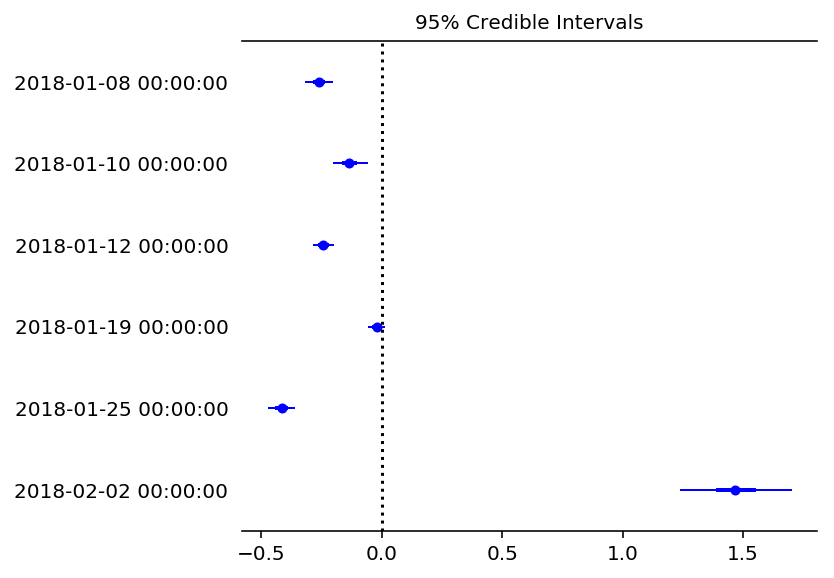

In [61]:
pm.forestplot(shift_trace, varnames=['mu_shift'], ylabels=[str(i) for i in sorted(set(data['date']))])